In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tifffile as tiff
import torchvision.models as models
import wandb
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# PATHS
HS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\Kaggle_Prepared\train\HS"
CHECKPOINT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# CONSTANTS
ALL_BANDS = 125
TARGET_HW = (64, 64)
VAL_RATIO = 0.2
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 0

# Set Seed
torch.manual_seed(SEED)
np.random.seed(SEED)
print(device)


cuda


In [2]:
def compute_global_stats(img_dir, bands=125):
    print("Computing global stats (STRICT Mode)...")
    files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.tif', '.tiff'))])
    channel_sum = np.zeros(bands, dtype=np.float64)
    channel_sum_sq = np.zeros(bands, dtype=np.float64)
    pixel_num = 0
    
    error_log = []
    valid_files = []
    
    for f in tqdm(files):
        path = os.path.join(img_dir, f)
        try:
            img = tiff.imread(path).astype(np.float32)
            
            # HWC Check
            if img.ndim == 3 and img.shape[-1] == bands:
                img = np.transpose(img, (2, 0, 1))
            elif img.ndim == 2: 
                img = img[None, :, :]
            
            # STRICT ASSERTION
            if img.shape[0] != bands:
                 raise ValueError(f"Channel mismatch: Expected {bands}, got {img.shape[0]}")
            
            pixels = img.reshape(bands, -1)
            channel_sum += pixels.sum(axis=1)
            channel_sum_sq += (pixels ** 2).sum(axis=1)
            pixel_num += pixels.shape[1]
            valid_files.append(f)
            
        except Exception as e:
            error_log.append(f"{f}: {str(e)}")
    
    if error_log:
        print(f"WARNING: {len(error_log)} files failed validation. See hs_data_errors.txt")
        with open(r"d:/HocTap/NCKH_ThayDoNhuTai/Challenges/Notebooks/00_baseline/hs_data_errors.txt", 'w') as log:
            log.write("\n".join(error_log))
            
    mean = channel_sum / pixel_num
    std = np.sqrt(channel_sum_sq / pixel_num - mean ** 2)
    return mean, std, valid_files

# Compute and filter files
full_mean, full_std, valid_files = compute_global_stats(HS_DIR, ALL_BANDS)
print("Global Mean[0:5]:", full_mean[:5])
# Update global file list
all_files = valid_files # OVERRIDE with only valid files


Computing global stats (STRICT Mode)...


100%|██████████| 600/600 [00:00<00:00, 745.43it/s]

Global Mean[0:5]: [268.73987091 321.83592552 349.92532392 366.65705881 377.42041115]


In [3]:
def label_from_filename(f): return f.split('_')[0]

class HSFlexibleDataset(Dataset):
    def __init__(self, img_dir, file_list, band_indices=None, augment=False, mean=None, std=None):
        self.img_dir = img_dir
        self.files = file_list
        self.augment = augment
        self.band_indices = band_indices # If None, use all
        
        # Handle Mean/Std Subset
        if band_indices is not None:
            self.mean = torch.tensor(mean[band_indices]).view(-1, 1, 1).float()
            self.std = torch.tensor(std[band_indices]).view(-1, 1, 1).float()
            self.target_c = len(band_indices)
        else:
            self.mean = torch.tensor(mean).view(-1, 1, 1).float()
            self.std = torch.tensor(std).view(-1, 1, 1).float()
            self.target_c = len(mean)

        # Labels
        all_labels = sorted({label_from_filename(f) for f in self.files})
        self.c2i = {c: i for i, c in enumerate(all_labels)}
        self.y = [self.c2i[label_from_filename(f)] for f in self.files]

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.files[idx])
        arr = tiff.imread(path).astype(np.float32)
        
        # Robust Dims from compute_global_stats
        if arr.ndim == 3:
            # Check if HWC (heuristic: last dim close to 125)
            if arr.shape[-1] >= 120 and arr.shape[-1] <= 130:
                arr = np.transpose(arr, (2, 0, 1))
        elif arr.ndim == 2: 
            arr = arr[None, :, :]
        
        # Fix Channel Count to 125
        c = arr.shape[0]
        if c > 125:
            arr = arr[:125, :, :]
        elif c < 125:
            pad = np.zeros((125 - c, arr.shape[1], arr.shape[2]), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)

        # SUBSET BANDS
        if self.band_indices is not None:
            arr = arr[self.band_indices, :, :]
            
        x = torch.from_numpy(arr)
        
        # Resize
        if x.shape[1:] != TARGET_HW:
            x = F.interpolate(x.unsqueeze(0), size=TARGET_HW, mode='bilinear', align_corners=False).squeeze(0)
            
        # Normalize
        x = (x - self.mean) / (self.std + 1e-8)
        
        # Augment
        if self.augment:
             if torch.rand(1) > 0.5: x = torch.flip(x, dims=[2])
             if torch.rand(1) > 0.5: x = torch.flip(x, dims=[1])
             k = torch.randint(0, 4, (1,)).item()
             x = torch.rot90(x, k, dims=[1, 2])
             
        return x, self.y[idx]


In [4]:
all_files = sorted([f for f in os.listdir(HS_DIR) if f.lower().endswith(('.tif', '.tiff'))])
labels = [label_from_filename(f) for f in all_files]
ids = np.arange(len(all_files))

train_idx, val_idx = train_test_split(ids, test_size=VAL_RATIO, random_state=SEED, stratify=labels)
train_files = [all_files[i] for i in train_idx]
val_files = [all_files[i] for i in val_idx]

print(f"Train: {len(train_files)}, Val: {len(val_files)}")


Train: 480, Val: 120


In [5]:
class GatedResNet(nn.Module):
    def __init__(self, num_classes, pretrained_path=None):
        super().__init__()
        # 125 bands
        ALL_BANDS = 125 
        self.gate = nn.Parameter(torch.zeros(ALL_BANDS))
        
        # Initialize Backbone
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Adapt Conv1 for 125 channels
        old = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(ALL_BANDS, old.out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        
        # --- FIX: Set FC before loading weights to match checkpoint shape ---
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
        # Load Pretrained HS-Full Weights if available
        if pretrained_path and os.path.exists(pretrained_path):
            print(f"Loading backbone from {pretrained_path}")
            state_dict = torch.load(pretrained_path)
            try:
                self.backbone.load_state_dict(state_dict, strict=False)
            except Exception as e:
                # If loading fails, it might be due to keys mismatch, but we fixed the shape issue.
                print(f"Minor loading warning: {e}")
        else:
            print("Using Scaled ImageNet Weights for Conv1")
            with torch.no_grad():
                 self.backbone.conv1.weight[:] = old.weight.mean(1, keepdim=True).repeat(1, ALL_BANDS, 1, 1)

    def forward(self, x):
        g = torch.sigmoid(self.gate).view(1, -1, 1, 1)
        x = x * g
        return self.backbone(x)


--- Training Gating Model (L1 Lambda=0.005) ---
Loading backbone from D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18.pth
Ep 1: Acc=0.500 | Loss=0.814
   Gate: Sum=62.45 | Std=0.0201 | Min/Max=0.471/0.523
Ep 2: Acc=0.508 | Loss=0.713
   Gate: Sum=62.38 | Std=0.0274 | Min/Max=0.460/0.531
Ep 3: Acc=0.608 | Loss=0.618
   Gate: Sum=62.36 | Std=0.0230 | Min/Max=0.461/0.526
Ep 4: Acc=0.567 | Loss=0.575
   Gate: Sum=62.33 | Std=0.0249 | Min/Max=0.462/0.532
Ep 5: Acc=0.583 | Loss=0.539
   Gate: Sum=62.31 | Std=0.0209 | Min/Max=0.468/0.546
Ep 6: Acc=0.667 | Loss=0.573
   Gate: Sum=62.28 | Std=0.0215 | Min/Max=0.464/0.561
Ep 7: Acc=0.583 | Loss=0.514
   Gate: Sum=62.30 | Std=0.0164 | Min/Max=0.472/0.565
Ep 8: Acc=0.617 | Loss=0.474
   Gate: Sum=62.26 | Std=0.0133 | Min/Max=0.475/0.566
Ep 9: Acc=0.575 | Loss=0.453
   Gate: Sum=62.21 | Std=0.0116 | Min/Max=0.474/0.562
Ep 10: Acc=0.592 | Loss=0.401
   Gate: Sum=62.16 | Std=0.0136 | Min/Max=0.466/0.555
Ep 11: Acc=0.533 | Loss

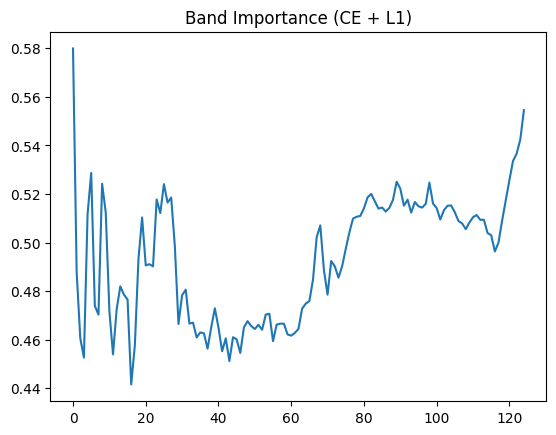

In [6]:
# --- GATING MODEL TRAINING (With Target-K Constraint) ---
def train_gate_model(l1_lambda=0.005, epochs=20):
    print(f"\n--- Training Gating Model (L1 Lambda={l1_lambda}) ---")
    
    # Re-initialize DataLoaders to ensure fresh start
    t_ds = HSFlexibleDataset(HS_DIR, train_files, band_indices=None, augment=True, mean=full_mean, std=full_std)
    v_ds = HSFlexibleDataset(HS_DIR, val_files, band_indices=None, augment=False, mean=full_mean, std=full_std)
    t_loader = DataLoader(t_ds, batch_size=BATCH_SIZE, shuffle=True)
    v_loader = DataLoader(v_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    ckpt_path = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18.pth"
    model = GatedResNet(num_classes=3, pretrained_path=ckpt_path).to(device)
    
    gate_params = [p for n, p in model.named_parameters() if 'gate' in n]
    backbone_params = [p for n, p in model.named_parameters() if 'gate' not in n]
    
    optimizer = optim.AdamW([
        {'params': gate_params, 'lr': 1e-2},
        {'params': backbone_params, 'lr': 1e-4}
    ], weight_decay=1e-4)
    
    crit = nn.CrossEntropyLoss()
    
    for ep in range(epochs):
        model.train()
        
        gate_grad_sum = 0.0
        steps = 0
        loss_avg = 0.0
        
        for x, y in t_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            cel = crit(out, y)
            
            # --- APPROACH A: CE + L1 Sparsity ---
            # Penalize the mean of gate values to encourage sparsity
            # No Target-K constraint. We just want meaningful ranking.
            sig_gate = torch.sigmoid(model.gate)
            l1_loss = l1_lambda * sig_gate.mean()
            
            loss = cel + l1_loss
            
            loss.backward()
            
            if model.gate.grad is not None:
                gate_grad_sum += model.gate.grad.abs().mean().item()
                steps += 1
            optimizer.step()
            loss_avg += loss.item()
            
        # Validation
        model.eval()
        corr = 0; tot = 0
        with torch.no_grad():
            g_vals = torch.sigmoid(model.gate)
            g_std = g_vals.std().item()
            g_sum = g_vals.sum().item()
            g_min = g_vals.min().item()
            g_max = g_vals.max().item()
            
            for x, y in v_loader:
                out = model(x.to(device))
                corr += (out.argmax(1) == y.to(device)).sum().item()
                tot += x.size(0)
        acc = corr/tot
        
        print(f"Ep {ep+1}: Acc={acc:.3f} | Loss={loss_avg/len(t_loader):.3f}")
        print(f"   Gate: Sum={g_sum:.2f} | Std={g_std:.4f} | Min/Max={g_min:.3f}/{g_max:.3f}")
        
    return torch.sigmoid(model.gate).detach().cpu().numpy()

# Execute Gating Training
gate_values = train_gate_model(l1_lambda=0.005, epochs=20)
plt.plot(gate_values.flatten())
plt.title("Band Importance (CE + L1)")
plt.show()


In [7]:
# Rank bands
sorted_indices = np.argsort(gate_values)[::-1] # Descending
print("Top 10 Bands:", sorted_indices[:10])
print("Top 20 Bands:", sorted_indices[:20])


Top 10 Bands: [  0 124 123 122 121   5 120  89  98   8]
Top 20 Bands: [  0 124 123 122 121   5 120  89  98   8  25  90  82  81  27  23  92  88
 119  83]


In [8]:
def train_model_variant(k, top_idx, mode='scratch'):
    print(f"   Mode: {mode.upper()}")
    t_ds = HSFlexibleDataset(HS_DIR, train_files, band_indices=top_idx, augment=True, mean=full_mean, std=full_std)
    v_ds = HSFlexibleDataset(HS_DIR, val_files, band_indices=top_idx, augment=False, mean=full_mean, std=full_std)
    t_loader = DataLoader(t_ds, batch_size=BATCH_SIZE, shuffle=True)
    v_loader = DataLoader(v_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model = models.resnet18(weights=None) # Init base
    old = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).conv1
    model.conv1 = nn.Conv2d(k, old.out_channels, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 3)
    
    # INITIALIZATION LOGIC
    if mode == 'scratch':
        with torch.no_grad():
             model.conv1.weight[:] = old.weight.mean(1, keepdim=True).repeat(1, k, 1, 1)
    elif mode == 'finetune':
        ckpt_path = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18.pth"
        full_state = torch.load(ckpt_path)
        if 'conv1.weight' in full_state:
             full_conv1_w = full_state.pop('conv1.weight')
             model.load_state_dict(full_state, strict=False)
             with torch.no_grad():
                 model.conv1.weight[:] = full_conv1_w[:, top_idx, :, :]
        else:
             model.load_state_dict(full_state, strict=False)
    
    model = model.to(device)
    opt = optim.AdamW(model.parameters(), lr=1e-4)
    crit = nn.CrossEntropyLoss()
    
    best_acc = 0.0
    save_path = os.path.join(CHECKPOINT_DIR, f"best_top{k}_{mode}.pth")
    
    for ep in range(10):
        model.train()
        for x, y in t_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()
        
        model.eval()
        corr = 0; tot = 0
        with torch.no_grad():
            for x, y in v_loader:
                 out = model(x.to(device))
                 corr += (out.argmax(1) == y.to(device)).sum().item()
                 tot += x.size(0)
        acc = corr/tot
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
    
    return best_acc


In [9]:
# --- RANDOM-30 BASELINE (Check #6) ---
print("\n=== Running Random-30 Baseline ===")
# Select 30 random indices
random_idx_30 = sorted(np.random.choice(range(ALL_BANDS), 30, replace=False))
print("Random 30 Indices:", random_idx_30)

acc_rand = train_model_variant(30, random_idx_30, mode='scratch')
print(f"Random-30 Scratch Accuracy: {acc_rand:.3f}")



=== Running Random-30 Baseline ===
Random 30 Indices: [0, 4, 10, 11, 12, 18, 19, 24, 26, 27, 31, 36, 42, 44, 45, 47, 53, 56, 67, 76, 77, 78, 91, 93, 96, 101, 108, 114, 116, 123]
   Mode: SCRATCH
Random-30 Scratch Accuracy: 0.650


In [10]:
results = {}
for k in [10, 20, 30]:
    print(f"\n=== Evaluating Top-{k} ===")
    # Ensure we use sorted indices to maintain channel order consistency
    top_idx = sorted(sorted_indices[:k])
    
    # Train Scratch
    acc_scratch = train_model_variant(k, top_idx, mode='scratch')
    
    # Train Finetune
    acc_finetune = train_model_variant(k, top_idx, mode='finetune')
    
    results[k] = {'scratch': acc_scratch, 'finetune': acc_finetune}
    print(f"   Result: Scratch={acc_scratch:.3f}, Finetune={acc_finetune:.3f}")

print("\n=== FINAL RESULTS ===")
for k, res in results.items():
    print(f"Top-{k}: Scratch={res['scratch']:.3f} | Finetune={res['finetune']:.3f}")



=== Evaluating Top-10 ===
   Mode: SCRATCH
   Mode: FINETUNE
   Result: Scratch=0.642, Finetune=0.642

=== Evaluating Top-20 ===
   Mode: SCRATCH
   Mode: FINETUNE
   Result: Scratch=0.675, Finetune=0.658

=== Evaluating Top-30 ===
   Mode: SCRATCH
   Mode: FINETUNE
   Result: Scratch=0.692, Finetune=0.658

=== FINAL RESULTS ===
Top-10: Scratch=0.642 | Finetune=0.642
Top-20: Scratch=0.675 | Finetune=0.658
Top-30: Scratch=0.692 | Finetune=0.658


In [12]:
# --- SUBMISSION GENERATION (FIXED) ---
class HSTestDataset(Dataset):
    def __init__(self, img_dir, band_indices=None, mean=None, std=None):
        self.img_dir = img_dir
        self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.tif', '.tiff'))])
        self.band_indices = band_indices
        
        # Handle Mean/Std Subset (Global Stats)
        if band_indices is not None:
            self.mean = torch.tensor(mean[band_indices]).view(-1, 1, 1).float()
            self.std = torch.tensor(std[band_indices]).view(-1, 1, 1).float()
        else:
            self.mean = torch.tensor(mean).view(-1, 1, 1).float()
            self.std = torch.tensor(std).view(-1, 1, 1).float()

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.img_dir, fname)
        arr = tiff.imread(path).astype(np.float32)
        
        # Robust Dims
        if arr.ndim == 3 and arr.shape[-1] >= 120 and arr.shape[-1] <= 130:
            arr = np.transpose(arr, (2, 0, 1))
        elif arr.ndim == 2: 
            arr = arr[None, :, :]
        
        # Force 125
        c = arr.shape[0]
        if c > 125: arr = arr[:125] 
        elif c < 125:
            pad = np.zeros((125 - c, arr.shape[1], arr.shape[2]), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)

        # Subset
        if self.band_indices is not None:
            arr = arr[self.band_indices]
            
        x = torch.from_numpy(arr)
        if x.shape[1:] != TARGET_HW:
            x = F.interpolate(x.unsqueeze(0), size=TARGET_HW, mode='bilinear', align_corners=False).squeeze(0)
            
        x = (x - self.mean) / (self.std + 1e-8)
        
        # Check #1: Assert shape for top-k
        if self.band_indices is not None:
             assert x.shape[0] == len(self.band_indices), f"Band mismatch: {x.shape[0]} vs {len(self.band_indices)}"
        
        return x, fname

def generate_submission(k, mode, top_idx):
    print(f"\nGenerating submission for Top-{k} ({mode})...")
    test_dir = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\Kaggle_Prepared\val\HS"
    ds = HSTestDataset(test_dir, band_indices=top_idx, mean=full_mean, std=full_std)
    
    # Check #5: Shuffle=False
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
    
    # Check #2: Mean/Std shapes
    print(f"Debug: Mean Shape: {ds.mean.shape}, Std Shape: {ds.std.shape}")
    
    # Load Model
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(k, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 3)
    
    ckpt = os.path.join(CHECKPOINT_DIR, f"best_top{k}_{mode}.pth")
    print(f"Loading checkpoint: {ckpt}")
    try:
        model.load_state_dict(torch.load(ckpt))
    except Exception as e:
        print(f"WARNING: Checkpoint load failed or mismatch! {e}")
        return # Stop if model is wrong
        
    model.to(device).eval()
    
    # --- CHECK #3: VALIDATION SANITY CHECK ---
    # Run a quick validation to ensure 0.658 compatibility
    print("Running sanity check on validation set...")
    v_ds = HSFlexibleDataset(HS_DIR, val_files, band_indices=top_idx, augment=False, mean=full_mean, std=full_std)
    v_loader = DataLoader(v_ds, batch_size=BATCH_SIZE, shuffle=False)
    corr = 0; tot = 0
    with torch.no_grad():
        for x, y in v_loader:
            out = model(x.to(device))
            corr += (out.argmax(1) == y.to(device)).sum().item()
            tot += x.size(0)
    val_acc = corr / tot
    print(f"Sanity Check Val Acc: {val_acc:.4f}")
    if val_acc < 0.55:
        print("!!! DANGER: Validation accuracy is suspiciously low. Are you using the right Model/Indices?")
    
    # Check #1 (Values) - Run one batch
    with torch.no_grad():
        try:
            x_debug, _ = next(iter(loader))
            # Print means of first and last channel to check for zeroing/normalization issues
            print(f"Debug Batch 0: x[0,0].mean={x_debug[0,0].mean():.4f}, x[0,{k-1}].mean={x_debug[0,k-1].mean():.4f}")
        except Exception as e: print(f"Debug batch failed: {e}")
        
    preds = []
    fnames = []
    
    with torch.no_grad():
        for x, names in loader:
            out = model(x.to(device))
            preds.extend(out.argmax(1).cpu().numpy())
            fnames.extend(names)
            
    # Map Indices back to Label Names
    label_map = {0: 'Health', 1: 'Other', 2: 'Rust'}
    
    # Check #4: Label Mapping Consistency
    all_train_labels = sorted({f.split('_')[0] for f in os.listdir(HS_DIR)})
    if len(all_train_labels) == 3:
         calc_map = {i: c for i, c in enumerate(all_train_labels)}
         if calc_map != label_map:
             print(f"CRITICAL WARNING: Label map mismatch! Train: {calc_map} vs Hardcoded: {label_map}")
             
    pred_labels = [label_map[p] for p in preds]
    
    import pandas as pd
    df = pd.DataFrame({'Id': fnames, 'Category': pred_labels})
    csv_path = os.path.join(CHECKPOINT_DIR, f"submission_top{k}_{mode}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved {csv_path}")

# --- EXECUTE SUBMISSION GENERATION ---
print("\n=== Generating Submissions ===")
for k in [10, 20, 30]:
    if 'sorted_indices' not in globals():
        print("Error: sorted_indices not found. Make sure previous cells were run.")
        break
    top_idx = sorted(sorted_indices[:k])
    
    # Generate for Scratch
    generate_submission(k, 'scratch', top_idx)
    
    # Generate for Finetune
    generate_submission(k, 'finetune', top_idx)



=== Generating Submissions ===

Generating submission for Top-10 (scratch)...
Debug: Mean Shape: torch.Size([10, 1, 1]), Std Shape: torch.Size([10, 1, 1])
Loading checkpoint: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_top10_scratch.pth
Running sanity check on validation set...
Sanity Check Val Acc: 0.6417
Debug Batch 0: x[0,0].mean=-0.3836, x[0,9].mean=1.0571
Saved D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_top10_scratch.csv

Generating submission for Top-10 (finetune)...
Debug: Mean Shape: torch.Size([10, 1, 1]), Std Shape: torch.Size([10, 1, 1])
Loading checkpoint: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_top10_finetune.pth
Running sanity check on validation set...
Sanity Check Val Acc: 0.6417
Debug Batch 0: x[0,0].mean=-0.3836, x[0,9].mean=1.0571
Saved D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_top10_finetune.csv

Generating submission for Top-20 (scratch)...
Debug: Mean Shape: torch.Size([20, 1, 1]), Std Shape: torc